<img src="http://www.finanze.gov.it/export/system/modules/it.gov.finanze.template/resources/img/logo-mef.gif"  style="float: left; width: 25%; margin-left: 8%; margin-top: 0.5em;">

<img src="http://www.opencoesione.gov.it/static/img/header/testata.png" style="float: right; width: 42%; margin-right: 8%; margin-top: 1.6em;">

<p style="clear: both;">

# Studio a livello comunale della spesa da OpenCivitas e dei finanziamenti a enti privati da dati OpenCoesione

### Finalità
Questo studio si propone come esempio delle seguenti opportunita' offerte dal Data Analytics Framework (DAF):
 - Integrare dati da fonti diverse permette di compiere analisi piu' complete in modo più semplice
 - L'impiego di strumenti open-source mette a disposizione tecniche di analisi molto avanzate, senza alcun costo di aggiornamento

### Dati e scopo dell'analisi
Questo notebook mette in relazione dati di spesa e raccolta IRPEF a livello comunale nel 2013 e dati sui finanziamenti con fondi di Coesione (FS, FSC e PAC) nel periodo 2007-2013. I due dataset sono:
######  OpenCivitas
http://www.opencivitas.it/open-data <br>
Riferimento ai campi usati: https://github.com/teamdigitale/daf-data-science/blob/master/opencivitas/analysis-opencivitas.ipynb

###### OpenCoesione 
http://www.opencoesione.gov.it/ <br>
Riferimento ai campi usati: http://www.opencoesione.gov.it/opendata/metadati_OC_2007_2013.xls

In [1]:
# python setup
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing
import sklearn.cluster
from matplotlib import pyplot as plt

## Caricamento dataset da integrare

In [2]:
# --- Spese e redditi da OpenCivitas
speseERedditiComune = pd.read_csv('../opencivitas/data/opencivitas_spesa_storica_dati_irpef.csv') #dati per anno
speseERedditiComune = speseERedditiComune[~speseERedditiComune['Codice Istat Comune'].isna()]
speseERedditiComune['Codice Istat Regione'] = speseERedditiComune['Codice Istat Regione'].astype(int)

padZeros = np.vectorize(lambda x: str(x).rjust(6, '0')) # some utils
speseERedditiComune['Codice Istat Lungo'] = \
(speseERedditiComune['Codice Istat Regione'].astype(str) + padZeros(speseERedditiComune['Codice Istat Comune'].astype(int))).astype(int)

# --- Soggetti e luoghi da OpenCoesione
soggettiLuoghi = pd.read_csv('../pac_opencoesione/SoggettiELuoghi.csv', low_memory=False)
soggettiLuoghi.drop(columns=['SOGG_COD_RUOLO', 'SOGG_PROGR_RUOLO'], inplace=True)
soggettiLuoghi = soggettiLuoghi[~soggettiLuoghi.COD_FORMA_GIURIDICA_SOGG.isna()]
assert not any(soggettiLuoghi['COD_COMUNE_SEDE_SOGG'].isna()), 'Unexpected missing codes'
soggettiLuoghi['COD_COMUNE_SEDE_SOGG'] = soggettiLuoghi['COD_COMUNE_SEDE_SOGG'].astype(int)
soggettiLuoghi['COD_COMUNE_LUOGO'] = soggettiLuoghi['COD_COMUNE_LUOGO'].fillna(value=-1).astype(int)

## Integrazione OpenCoesione and OpenCivitas

#### Estrazione fondi erogati a soggetti privati per cui la sede e' riferibile ad un Comune:

In [3]:
bEntePrivato = soggettiLuoghi.COD_FORMA_GIURIDICA_SOGG.str.startswith('1') & \
                    (soggettiLuoghi.COD_COMUNE_SEDE_SOGG != -1)

soggLuoghiPrivato = soggettiLuoghi[bEntePrivato]
fondiSoggetti = soggLuoghiPrivato.groupby(
                    'COD_COMUNE_SEDE_SOGG')['TOT_PAGAMENTI'].sum().sort_values(ascending=False).to_frame()
fondiSoggetti = fondiSoggetti[fondiSoggetti >0]

#### In OpenCivitas non vi sono dati solo per le 15 regioni a Statuto ordinario: controlliamo quanto e' grande la quota di fondi in OpenCoesione riferita a sedi soggetto mancanti in OpenCivitas

In [4]:
listaComuniOpenCiv = speseERedditiComune['Codice Istat Lungo'].drop_duplicates()
listaRegioniOpenCiv = speseERedditiComune[['Codice Istat Regione', 'Regione']].drop_duplicates()
print(listaRegioniOpenCiv.set_index('Codice Istat Regione').sort_values('Regione'))
print('''
Il totale dei fondi verso soggetti privati con Comune della sede disponibile nei dati è EUR %.4g, 
            di cui %.4g corrispondono a comuni in OpenCivitas) 
            
        ''' % (fondiSoggetti.sum(),
                fondiSoggetti[fondiSoggetti.index.isin(listaComuniOpenCiv.values)].sum()))

unioneComuniSoggetti = pd.merge(speseERedditiComune, fondiSoggetti,
                                how='left',left_on='Codice Istat Lungo', right_index = True)


                             Regione
Codice Istat Regione                
13                           ABRUZZO
17                        BASILICATA
18                          CALABRIA
15                          CAMPANIA
8                     EMILIA-ROMAGNA
12                             LAZIO
7                            LIGURIA
3                          LOMBARDIA
11                            MARCHE
14                            MOLISE
1                           PIEMONTE
16                            PUGLIA
9                            TOSCANA
10                            UMBRIA
5                             VENETO

Il totale dei fondi verso soggetti privati con Comune della sede disponibile nei dati è EUR 1.359e+10, 
            di cui 1.222e+10 corrispondono a comuni in OpenCivitas) 
            
        


In [5]:
# Plot preparation
plt.rcParams["figure.figsize"] = (18,12)
#plt.rcParams.update({'font.size': 16})
sns.set_context("talk")
dataLog=unioneComuniSoggetti[unioneComuniSoggetti.ANNO==2013].copy()
dataLog['TOT_PAGAMENTI'] = np.log10(dataLog.TOT_PAGAMENTI)
dataLog['Numero contribuenti'] = np.log10(dataLog['Numero contribuenti'])
dataLog = dataLog[~dataLog['TOT_PAGAMENTI'].isna()]
xLabelLog = 'Log del numero di contribuenti'
yLabelLog = 'Log Totale Pagamenti da fondi Coesione ad enti privati nel Comune'

#### Plot dei fondi ricevuti da enti privati rispetto al numero dei contribuenti nel Comune: <br> dispersione log-log con fit non parametrico ("lowess") e fit lineare per ciascuna Regione

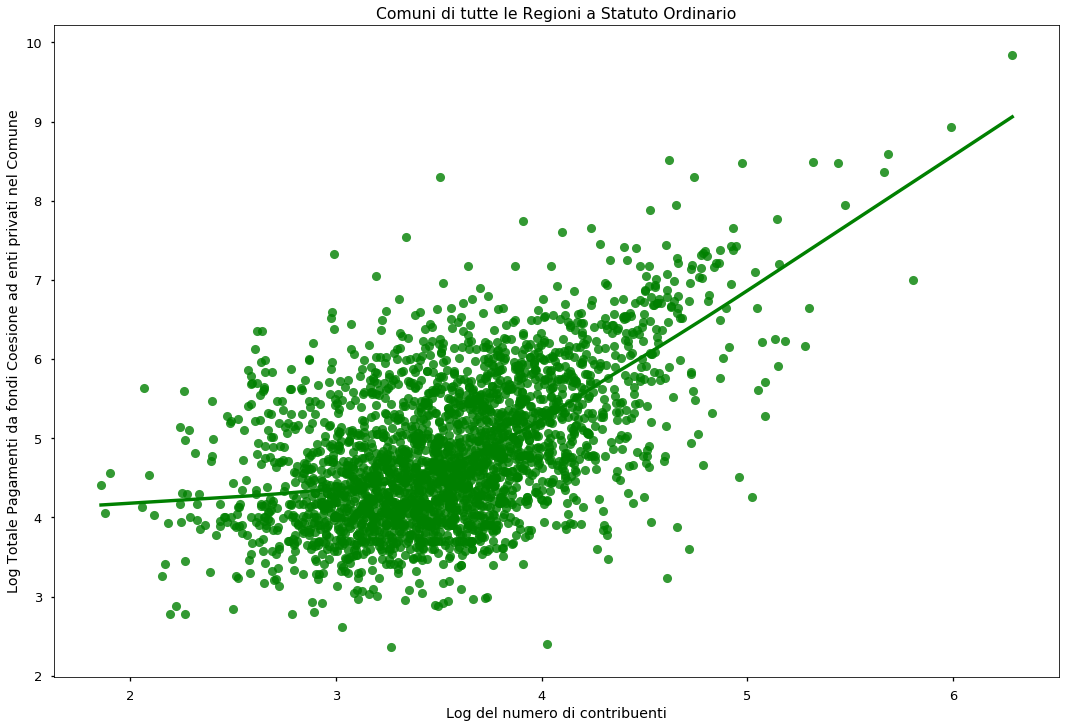

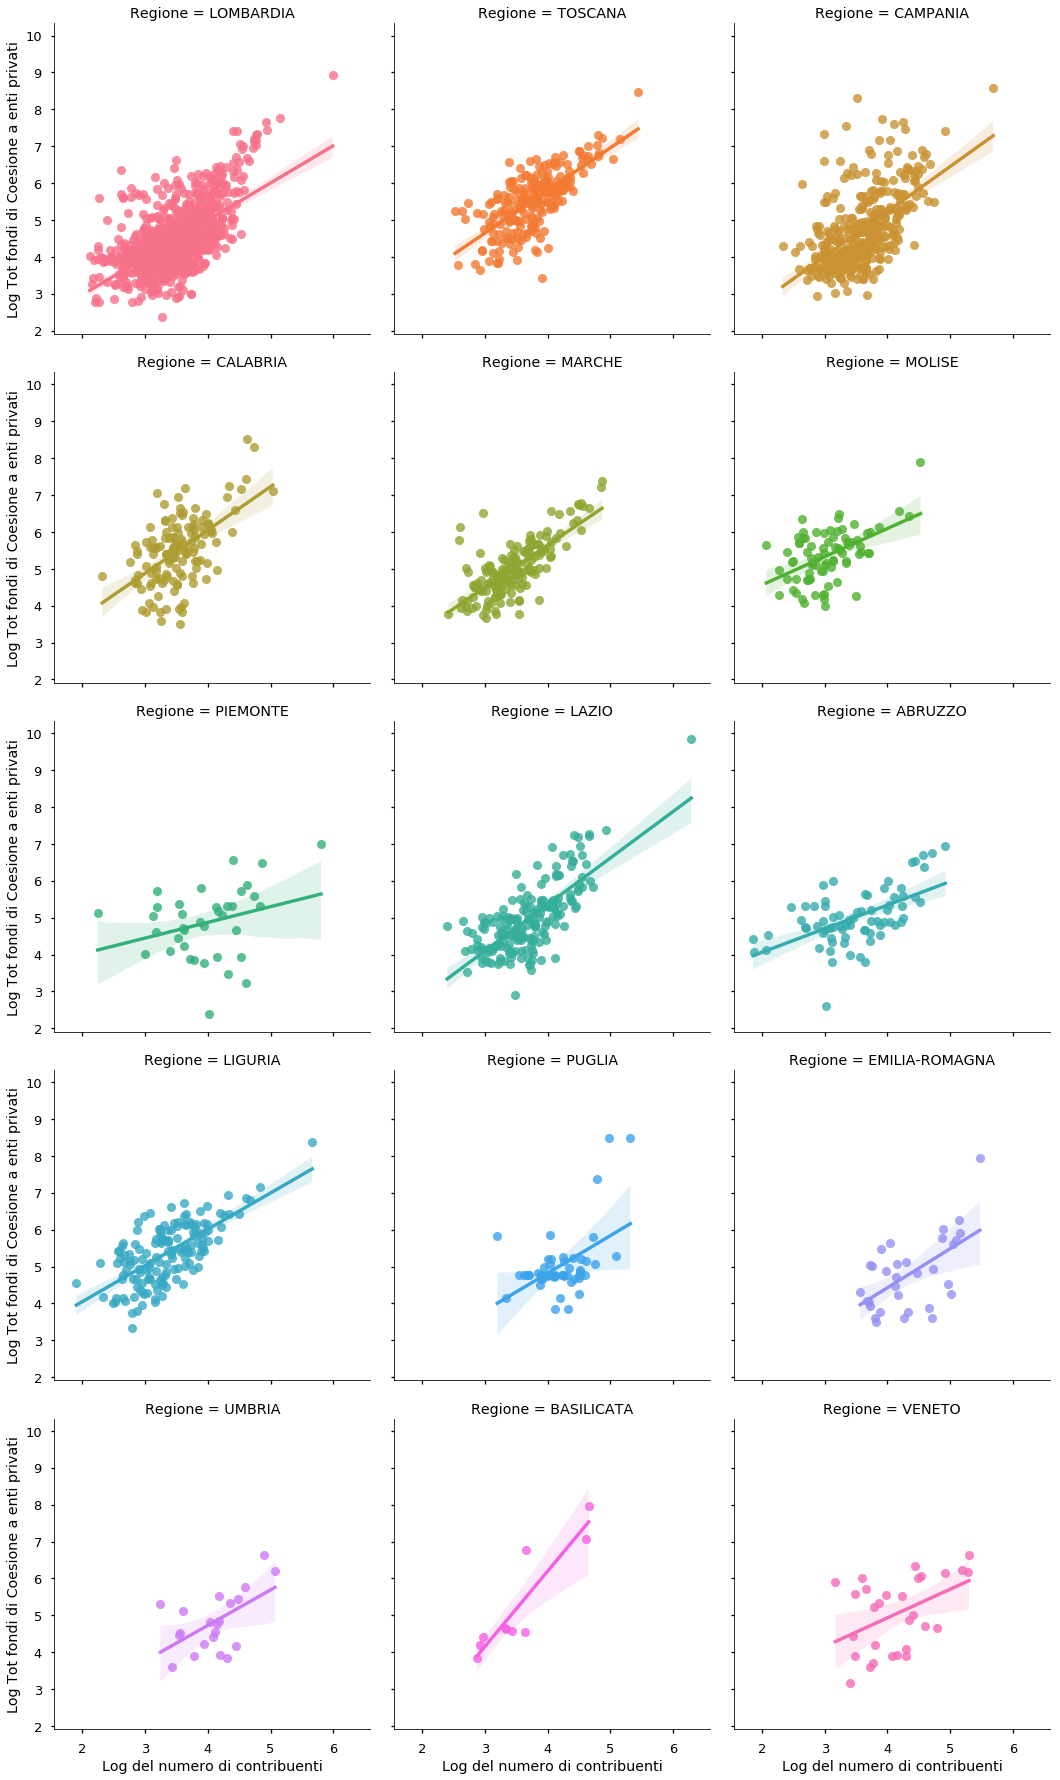

In [29]:
axAll = sns.regplot(x='Numero contribuenti', y='TOT_PAGAMENTI', 
                        data=dataLog, lowess=True, color = 'g')
axAll.set(xlabel =xLabelLog, ylabel=yLabelLog,
                        title='Comuni di tutte le Regioni a Statuto Ordinario')
yLabelShort = 'Log Tot fondi di Coesione a enti privati'
axSplit = sns.lmplot(x='Numero contribuenti', y='TOT_PAGAMENTI', data=dataLog, 
                        truncate=True, hue='Regione', col='Regione', col_wrap=3)
for ax in axSplit.axes:
    if ax.get_xlabel(): ax.set(xlabel=xLabelLog)
    if ax.get_ylabel(): ax.set(ylabel=yLabelShort) 
plt.show()


Come si vede dai grafici, Comuni di diverse Regioni mostrano tendenze molto diverse rispetto all'accesso ai fondi di Coesione: possiamo provare a spiegare queste differenze in termini di caratteristiche del Comune stesso, ad esempio la distribuzione della spesa fra le varie voci?

#### Clustering dei comuni per spesa

In [13]:
# declare clustering variables
dataSpesa=unioneComuniSoggetti[unioneComuniSoggetti.ANNO==2013].copy()
spesaNames = [c for c in dataSpesa.columns if c.startswith('costo') & ('totale' not in c)]

spesaMedia = np.log10(dataSpesa[spesaNames].divide(
    dataSpesa['Numero contribuenti'], axis='index')+1)

spesaMediaNorm = spesaMedia.copy()
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1)) #MinMax rescaling
spesaMediaNorm[spesaNames] = scaler.fit_transform(spesaMedia[spesaNames])

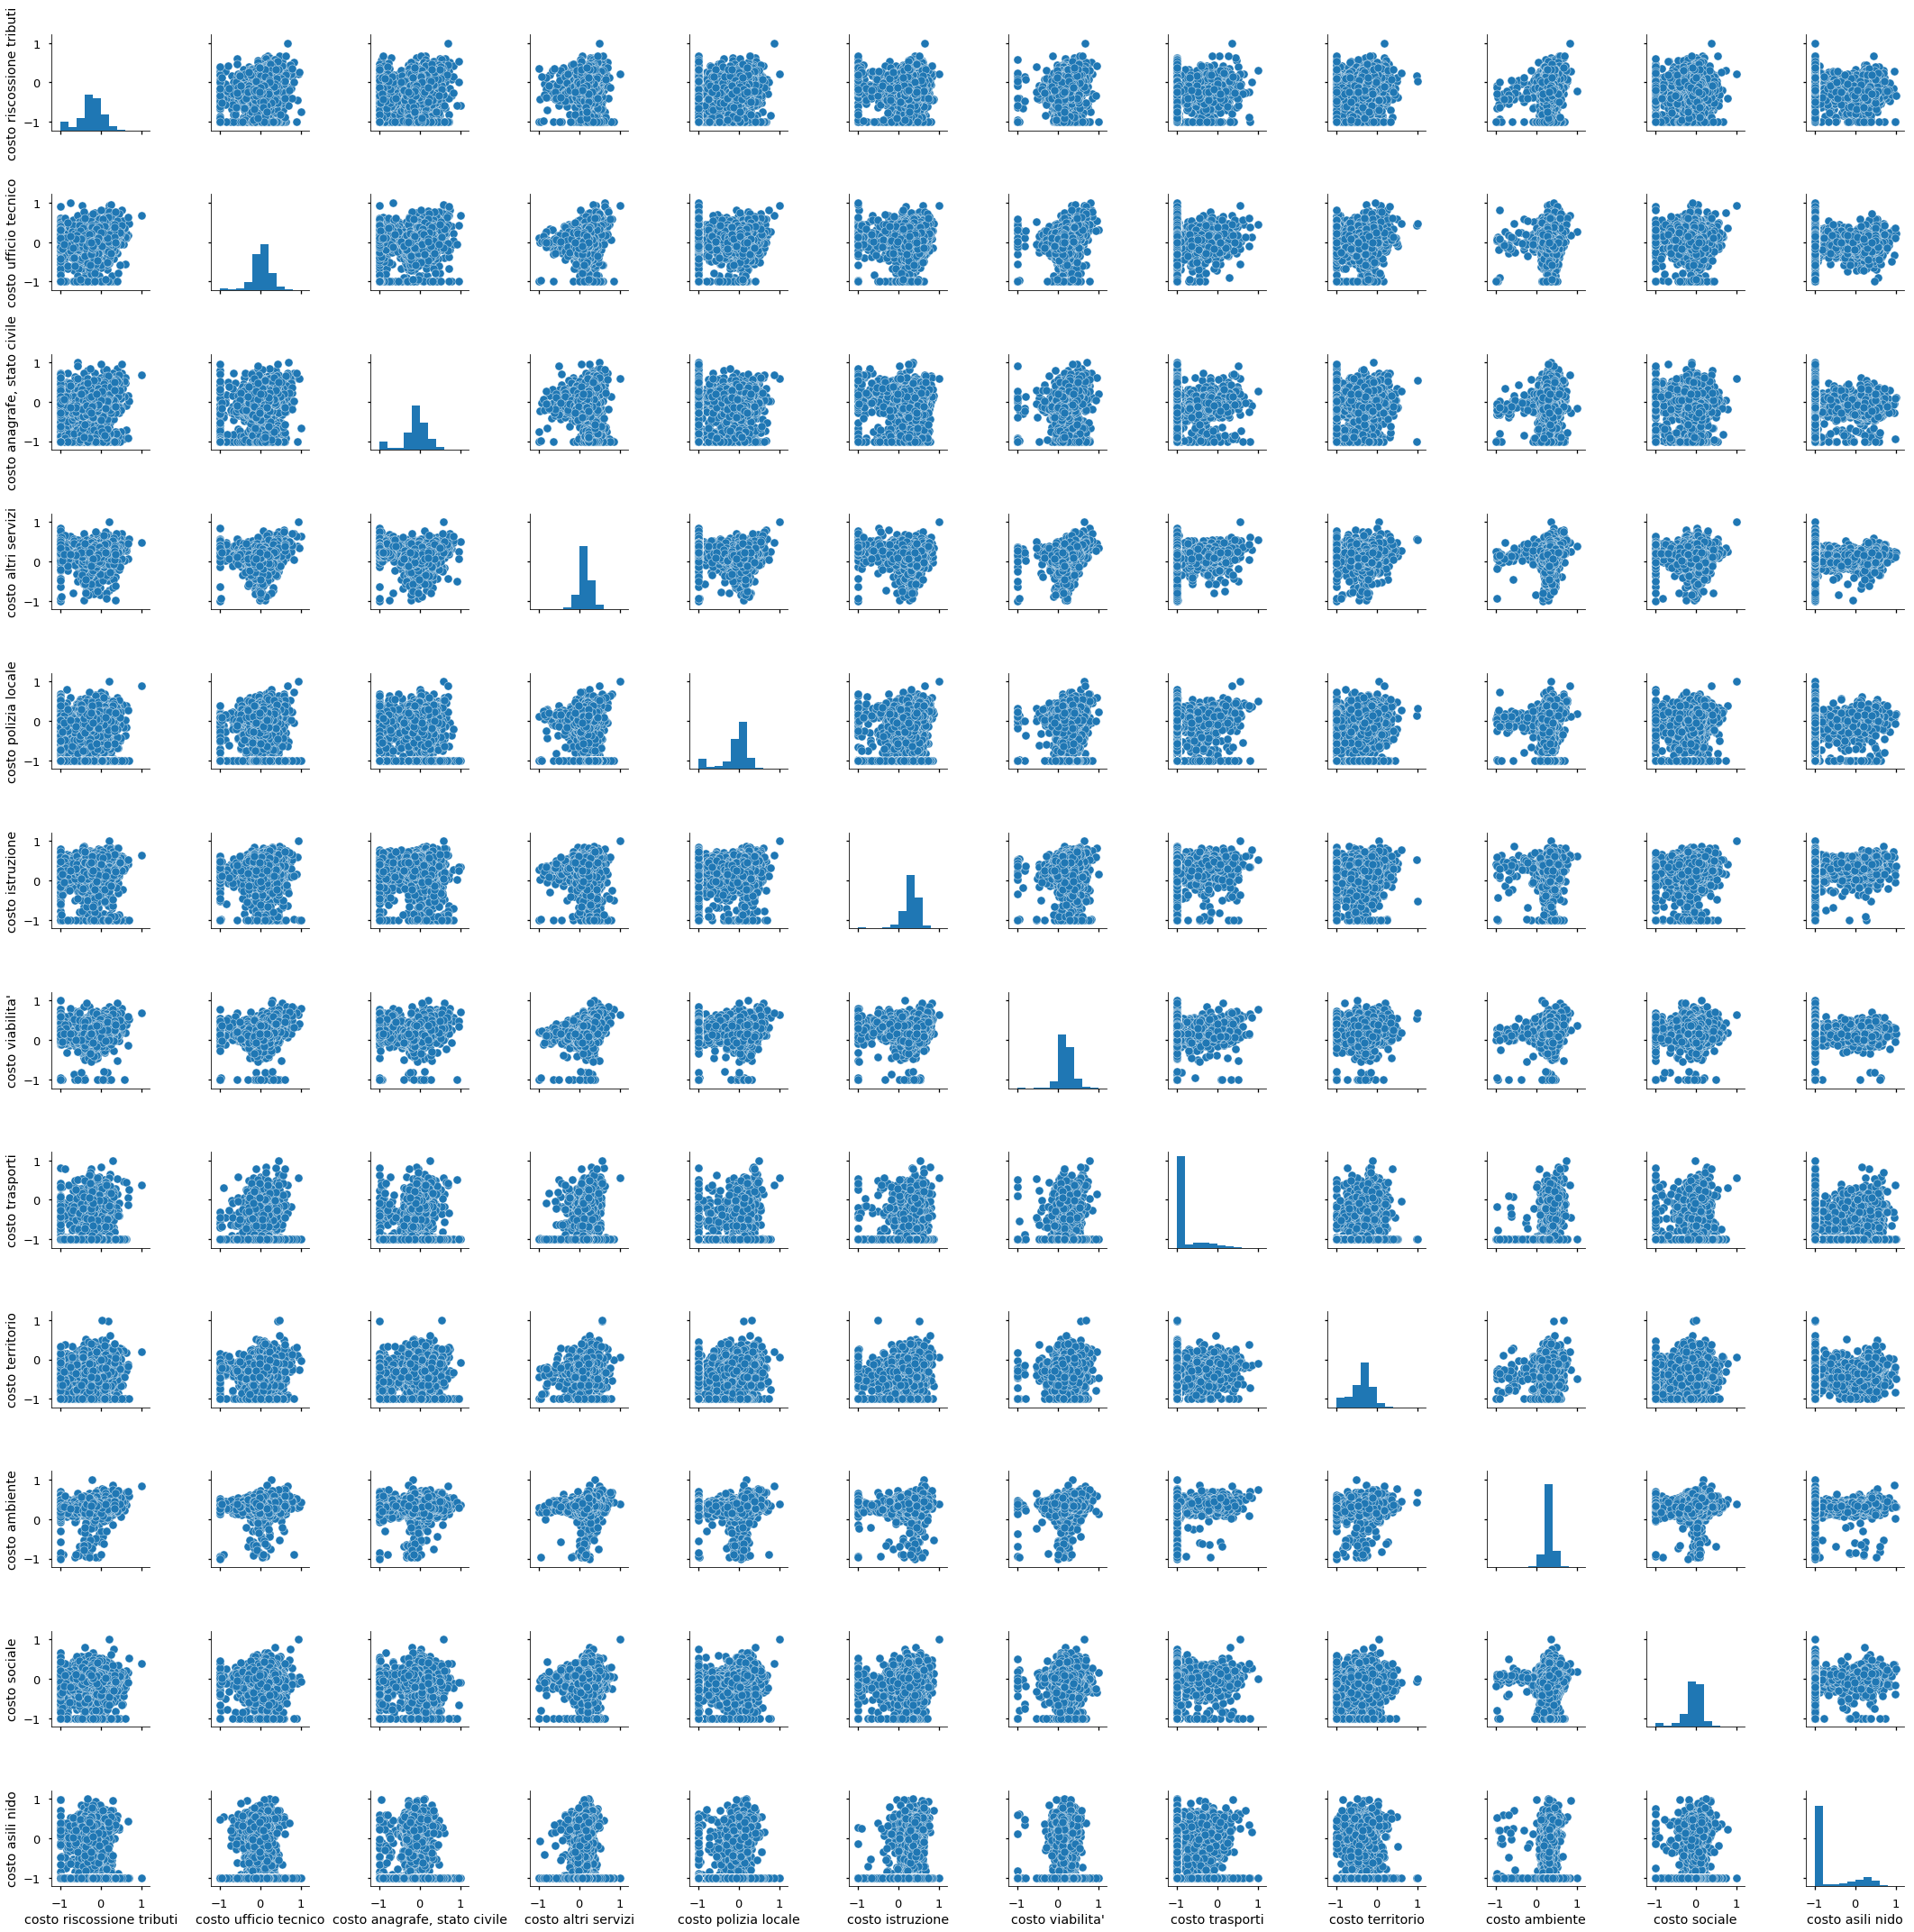

In [14]:
sns.pairplot(spesaMediaNorm); plt.show() #quite heavy to plot


#### Cerchiamo se vi sono dei cluster nei dati relativamente facili da individuare: calcoliamo l'errore di ricostruzione di K-means al variare del numero dei clusters

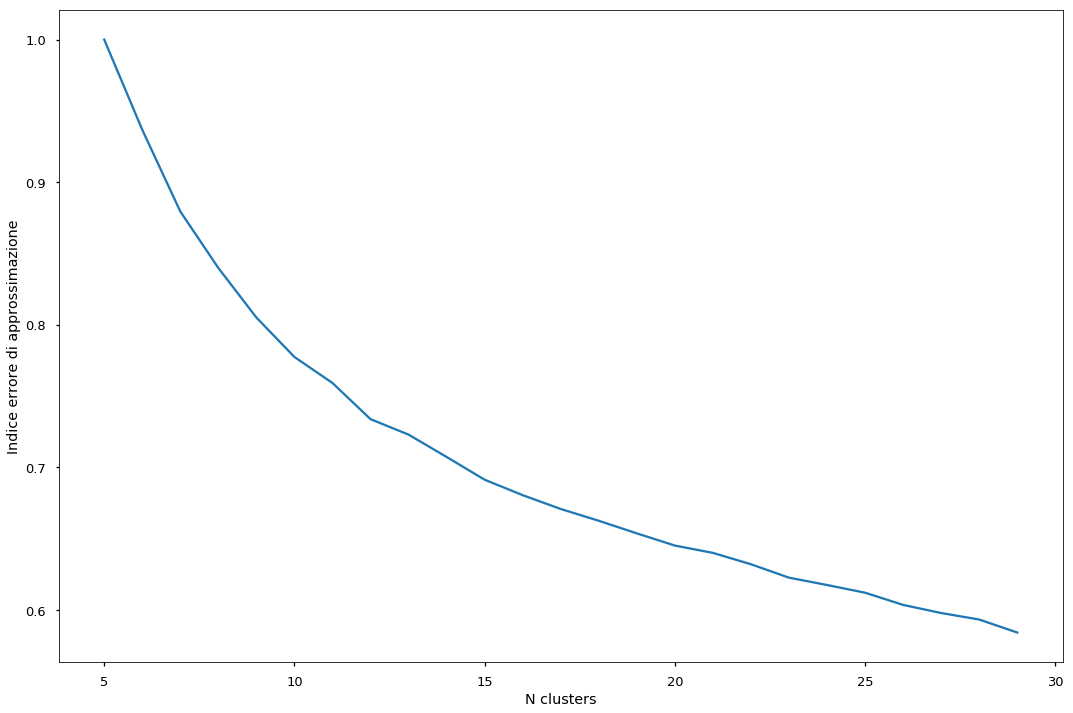

In [15]:
nClusters = np.arange(5,30)

def evaluate_errors(testClusters, data):
    errValue = np.zeros_like(testClusters)
    for i, k in enumerate(testClusters):
        Clusterer = sklearn.cluster.KMeans(n_clusters=k)
        Clusterer.fit(data)
        errValue[i] = Clusterer.inertia_
    return errValue

errValueNorm = evaluate_errors(nClusters, spesaMediaNorm)
plt.plot(nClusters, errValueNorm/errValueNorm.max())
plt.xlabel('N clusters'); plt.ylabel('Indice errore di approssimazione')
plt.show()

#### Non vi è una cuspide evidente nel grafico sopra. Usiamo t-SNE per provare a clusterizzare i comuni in base alle spese. <br> Iniziamo normalizzando i dati, in modo che  voci di spesa che hanno diversi ordini di grandezza vengano portate sullo stesso piano
Per informazioni su t-SNE, visitare https://distill.pub/2016/misread-tsne/

In [16]:
def fit_with_tSNE(df, EE=4, lrate=200, perp=30, nIter=600):
    # initalise t-SNE
    Fitter_tSNE = sklearn.manifold.TSNE(n_components=2,verbose=1, n_iter=nIter, 
                        early_exaggeration=EE, learning_rate=lrate, perplexity=perp)
    Fitter_tSNE.fit(df) # fit data
    
    X_embedded = Fitter_tSNE.embedding_
    df['x_tsne']= X_embedded[:,0]
    df['y_tsne']= X_embedded[:,1]
    # plot t-SNE output
    plt.figure()
    sns.regplot(x='x_tsne', y='y_tsne', data=df, fit_reg=False)
    plt.show()
    return df

def label_clusters(df, Clusterizer):
    # fit and label clusters
    Clusterizer.fit(df[['x_tsne','y_tsne']])
    df['cluster'] = Clusterizer.labels_
    # plot all clusters
    sns.lmplot(x='x_tsne', y='y_tsne',hue='cluster', data=df, fit_reg=False, size=8)
    plt.show()
    return df

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6640 samples in 0.014s...
[t-SNE] Computed neighbors for 6640 samples in 1.352s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6640
[t-SNE] Computed conditional probabilities for sample 2000 / 6640
[t-SNE] Computed conditional probabilities for sample 3000 / 6640
[t-SNE] Computed conditional probabilities for sample 4000 / 6640
[t-SNE] Computed conditional probabilities for sample 5000 / 6640
[t-SNE] Computed conditional probabilities for sample 6000 / 6640
[t-SNE] Computed conditional probabilities for sample 6640 / 6640
[t-SNE] Mean sigma: 0.177713
[t-SNE] KL divergence after 250 iterations with early exaggeration: 18.635124
[t-SNE] Error after 800 iterations: 1.811368


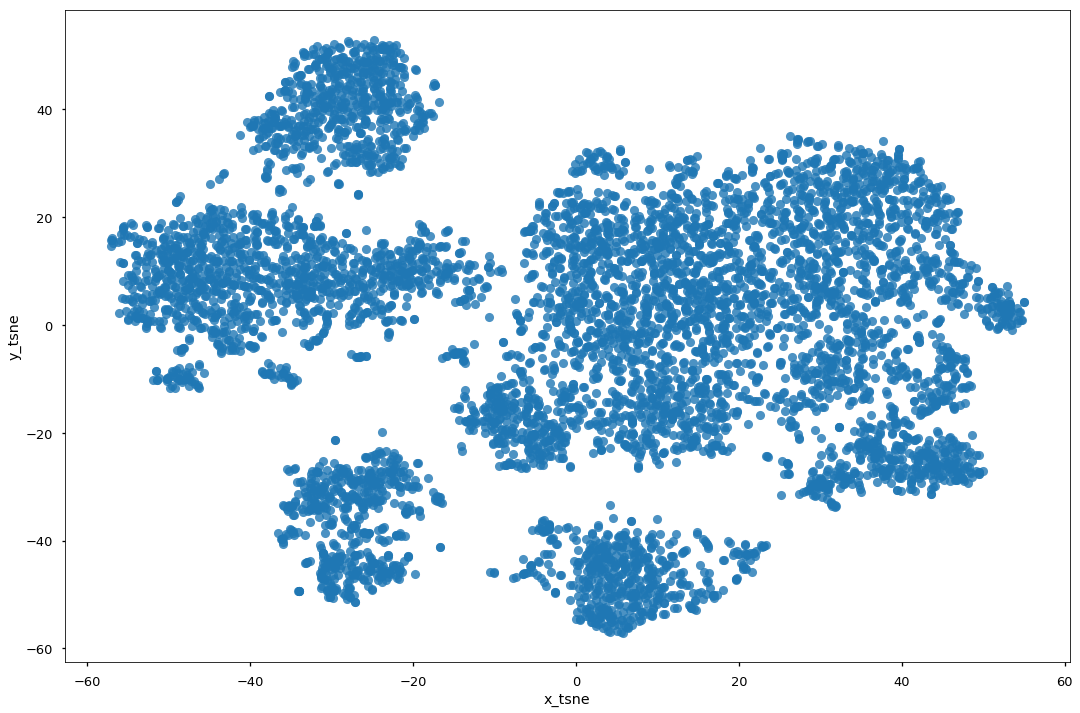

In [25]:
spesaMediaNorm = fit_with_tSNE(
    spesaMediaNorm.copy()[spesaNames], EE=4, lrate=150, nIter=800, perp=40)

Abbiamo visto che K-means non suggerisce un numero netto di clusters nei dati. 
Individuiamo i clusters nella versione 2D dei dati prodotta da t-SNE con l'obiettivo di definire 5/6 macroclusters.

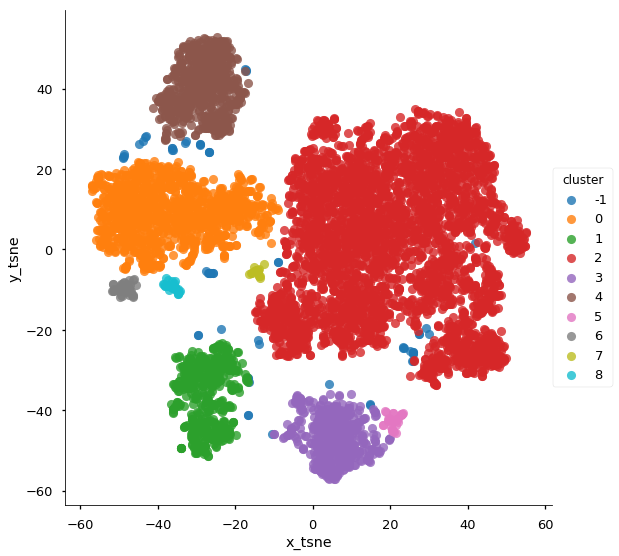

In [26]:
spesaMediaNorm = label_clusters(spesaMediaNorm, 
                        sklearn.cluster.DBSCAN(eps=3, min_samples=15))

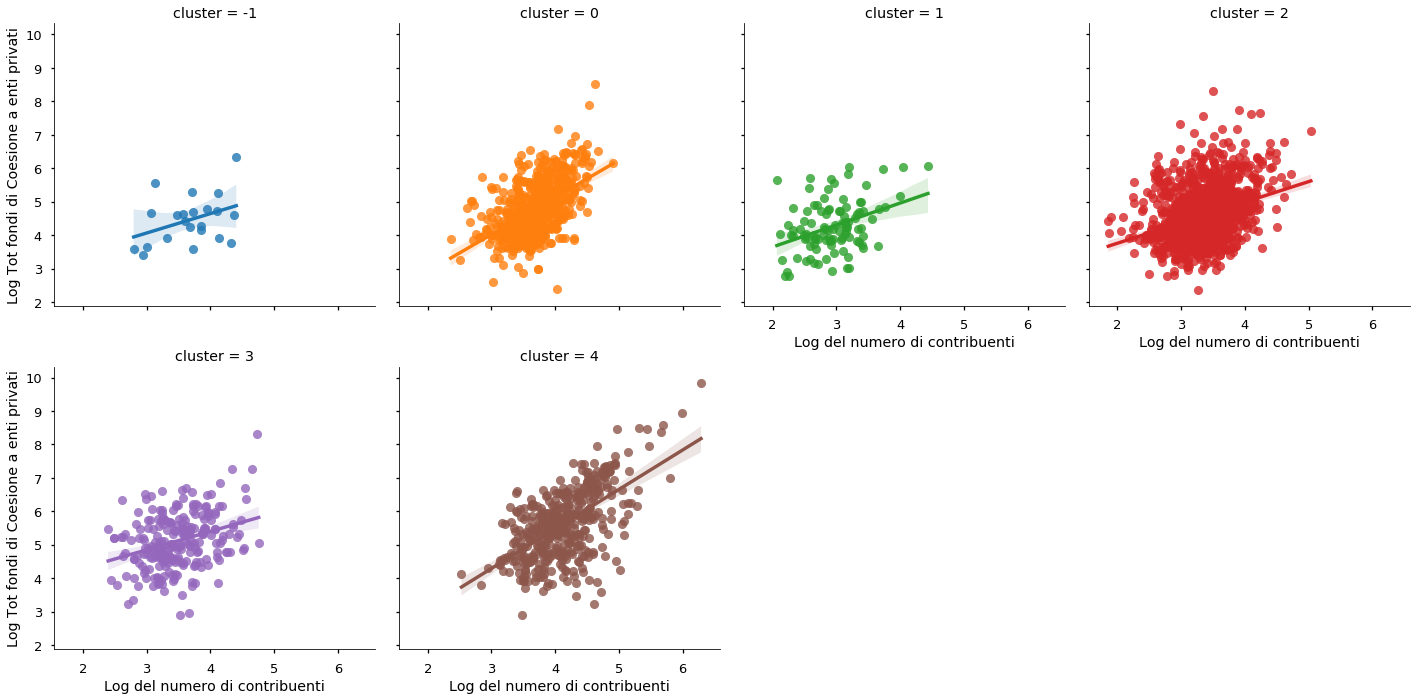

In [31]:
# assign the cluster labels we found and plot clusters instead of Regions
dataLog['cluster'] = spesaMediaNorm['cluster']
dataPlot = dataLog.groupby('cluster').filter(lambda x: x['Numero contribuenti'].count() > 15)
sns.set_context('talk')
axSplit = sns.lmplot(x='Numero contribuenti', y='TOT_PAGAMENTI', data=dataPlot, 
                    truncate=True, hue='cluster', col='cluster', col_wrap=4)
for ax in axSplit.axes:
    if ax.get_xlabel(): ax.set(xlabel=xLabelLog)
    if ax.get_ylabel(): ax.set(ylabel=yLabelShort) 

Dai cluster con la spesa media rinormalizzata fra le varie categorie non vediamo una suddivisione chiara rispetto all'entita' dei finanziamenti. La dispersione verticale dei vari cluster resta elevata, nonostante si veda che i trend sono diversi fra clusters.

Proviamo ora a ripetere il clustering usando i dati di spesa senza rinormalizzare il peso relativo delle varie voci.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6640 samples in 0.012s...
[t-SNE] Computed neighbors for 6640 samples in 1.995s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6640
[t-SNE] Computed conditional probabilities for sample 2000 / 6640
[t-SNE] Computed conditional probabilities for sample 3000 / 6640
[t-SNE] Computed conditional probabilities for sample 4000 / 6640
[t-SNE] Computed conditional probabilities for sample 5000 / 6640
[t-SNE] Computed conditional probabilities for sample 6000 / 6640
[t-SNE] Computed conditional probabilities for sample 6640 / 6640
[t-SNE] Mean sigma: 0.278086
[t-SNE] KL divergence after 250 iterations with early exaggeration: 7.007236
[t-SNE] Error after 700 iterations: 1.968675


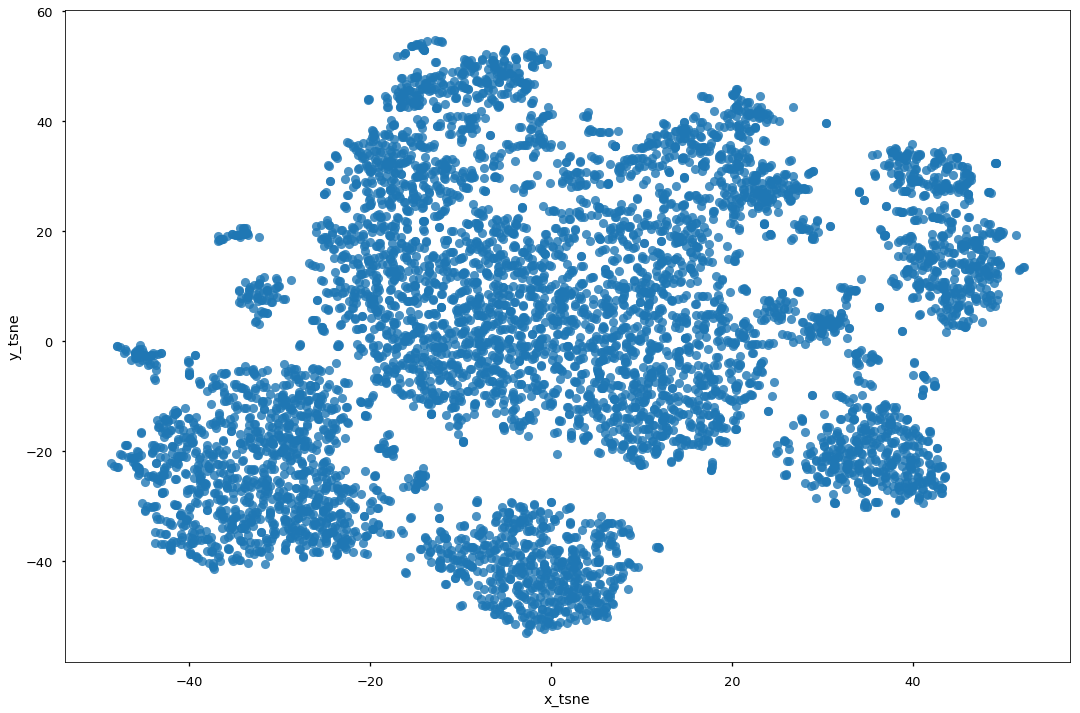

In [20]:
spesaMedia = fit_with_tSNE(
       spesaMedia.copy()[spesaNames], EE=2, lrate=120, nIter=700, perp=30)

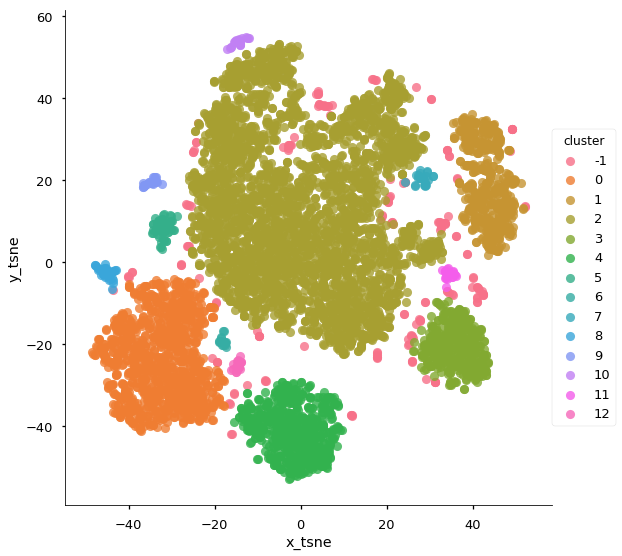

In [21]:
CL = sklearn.cluster.DBSCAN(eps=2.5, min_samples=15)
#alternative: CL = sklearn.cluster.AgglomerativeClustering(n_clusters=15)
spesaMedia = label_clusters(spesaMedia, CL)

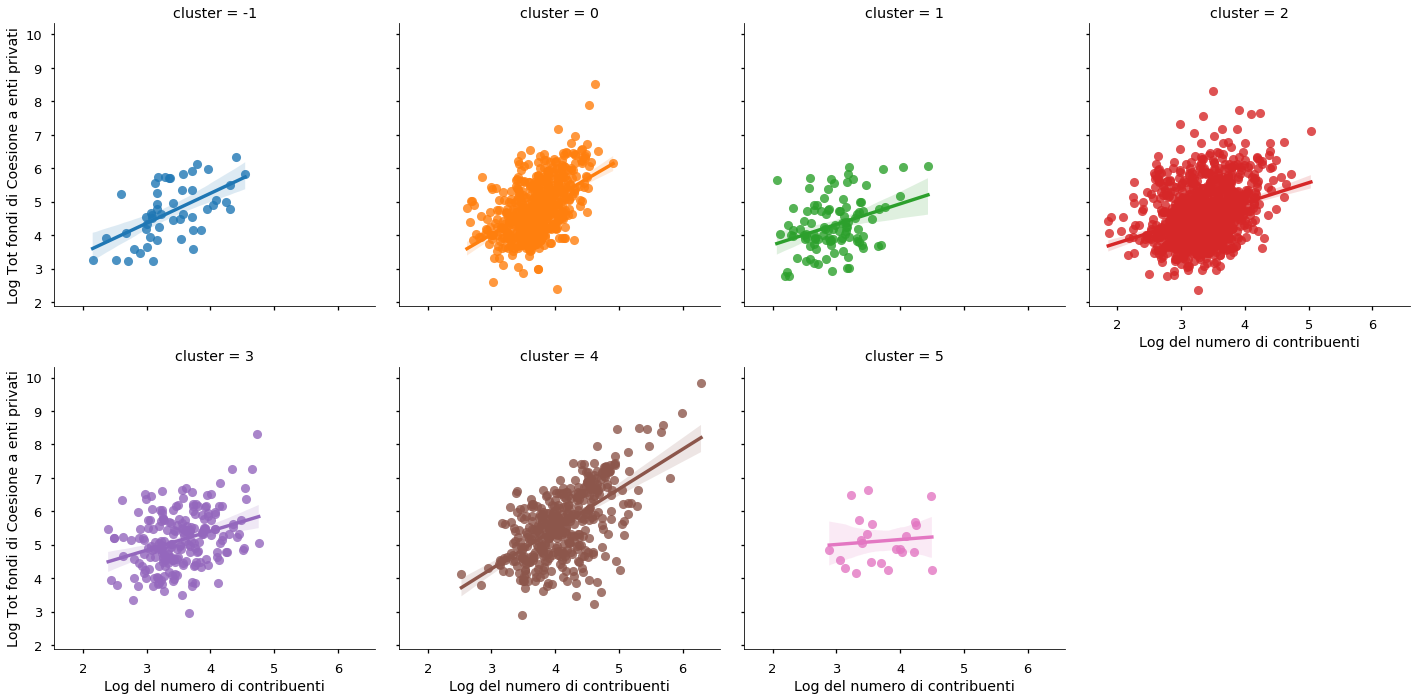

In [30]:
dataPlotAbs = dataLog.copy()
dataPlotAbs['cluster'] = spesaMedia['cluster']
dataPlotAbs = dataPlotAbs.groupby('cluster').filter(lambda x: x.iloc[:,0].count() > 10)
axSplit = sns.lmplot(x='Numero contribuenti', y='TOT_PAGAMENTI', data=dataPlotAbs, 
                    truncate=True, hue='cluster', col='cluster', col_wrap=4)
for ax in axSplit.axes:
    if ax.get_xlabel(): ax.set(xlabel=xLabelLog)
    if ax.get_ylabel(): ax.set(ylabel=yLabelShort) 

I cluster trovati sono molto simili ai precedenti. La distribuzione della spesa non è sufficiente a produrre diversi livelli di finanziamento per le aziende del Comune.

L'analisi potrebbe ora proseguire in due direzioni:
 - Caratterizzare i cluster di spesa e studiare la loro variabilità nel tempo
 - Includere i dati sui redditi nell'analisi e considerare la loro eventuale relazione con i finanziamenti registrati